In [49]:
import json 
import pandas as pd
from sklearn.model_selection import train_test_split
import featuretools as ft
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
df = pd.read_json('transactionsjson.json',lines=True)

In [3]:
#select relevant columns
df = df[[
     'creditLimit', 'availableMoney', 'transactionAmount',
    'transactionType', 'currentBalance', 'posEntryMode', 'cardPresent',
    'expirationDateKeyInMatch', 'isFraud', 'acqCountry', 'merchantCountryCode',
    'posConditionCode', 'transactionDateTime', 'merchantName',
    'accountOpenDate', 'dateOfLastAddressChange'
]]

In [4]:
#split data 

X = df.drop('isFraud', axis=1)
y = df.isFraud

In [5]:
#Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=123,)

In [6]:
es = ft.EntitySet(id="transactionData")

In [7]:
#create entity set containing dataframes and relationships

from featuretools import variable_types as vtypes
#variable_types = {
    
  #  'availableMoney': vtypes.Numeric, 
  #  'transactionAmount': vtypes.Numeric,
  #  'currentBalance':vtypes.Numeric,
  #  }

es.entity_from_dataframe(entity_id='transactions',dataframe=X_train,
                      index='index', )


C:\ProgramData\Anaconda3\lib\site-packages\featuretools\entityset\entity.py:611: UserWarning: index index not found in dataframe, creating new integer column
  "integer column".format(index))


Entityset: transactionData
  Entities:
    transactions [Rows: 550454, Columns: 16]
  Relationships:
    No relationships

In [8]:
es = es.normalize_entity(base_entity_id="transactions",
                       new_entity_id="transactionAmounts",
                         index="transactionAmount", )

In [9]:
es = es.normalize_entity(base_entity_id="transactions",
                       new_entity_id="transactionTypes",
                         index="transactionType", copy_variables=['creditLimit',"merchantName","availableMoney","currentBalance"])

In [10]:
es = es.normalize_entity(base_entity_id="transactions",
                       new_entity_id="merchant",
                         index="merchantName")

In [11]:
es = es.normalize_entity(base_entity_id="transactions",
                       new_entity_id="creditLimit",
                         index="creditLimit")

In [12]:
es = es.normalize_entity(base_entity_id="transactions",
                       new_entity_id="availableMoney",
                         index="availableMoney")

In [13]:
es = es.normalize_entity(base_entity_id="transactions",
                       new_entity_id="currentBalance",
                         index="currentBalance")

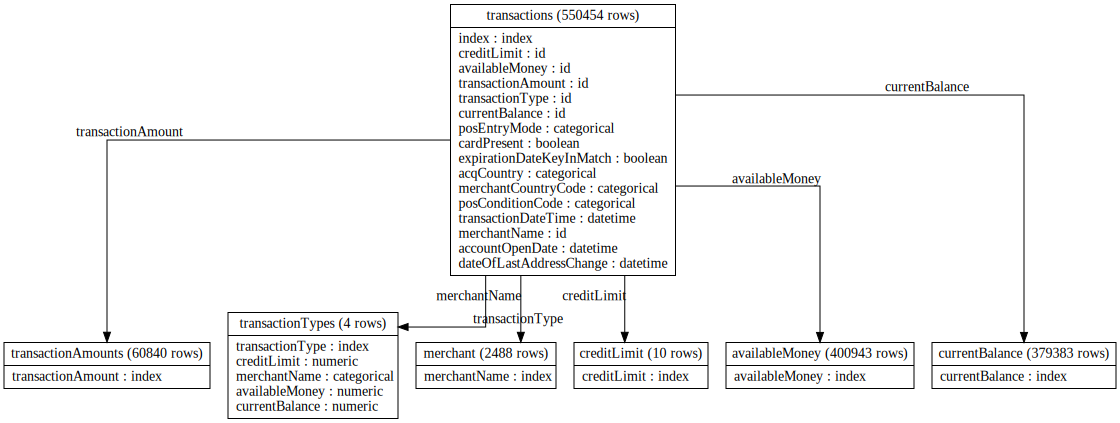

In [14]:
es.plot()

In [15]:
#create features from entityset
feature_matrix,feature_names = ft.dfs(entityset = es, target_entity = 'transactions',
                       
                       features_only=False,verbose=True,n_jobs = -1)

feature_matrix.head()

Built 154 features
EntitySet scattered to 8 workers in 47 seconds                                 
Elapsed: 16:27 | Progress: 100%|███████████████████████████████████████████████


,creditLimit,availableMoney,transactionAmount,transactionType,currentBalance,posEntryMode,cardPresent,expirationDateKeyInMatch,acqCountry,merchantCountryCode,...,currentBalance.NUM_UNIQUE(transactions.availableMoney),currentBalance.NUM_UNIQUE(transactions.creditLimit),currentBalance.NUM_UNIQUE(transactions.merchantCountryCode),currentBalance.NUM_UNIQUE(transactions.merchantName),currentBalance.NUM_UNIQUE(transactions.posConditionCode),currentBalance.NUM_UNIQUE(transactions.posEntryMode),currentBalance.NUM_UNIQUE(transactions.transactionAmount),currentBalance.NUM_UNIQUE(transactions.transactionType),currentBalance.PERCENT_TRUE(transactions.cardPresent),currentBalance.PERCENT_TRUE(transactions.expirationDateKeyInMatch)
index,,,,,,,,,,,,,,,,,,,,,
0,2500,1976.74,60.98,PURCHASE,523.26,09,False,False,US,US,...,1.0,1,1,1,1,1,1.0,1,0.000000,0.000000
1,250,250.00,90.93,PURCHASE,0.00,02,True,False,US,US,...,10.0,10,5,2079,4,6,14613.0,4,0.445497,0.001274
2,20000,18632.07,261.07,PURCHASE,1367.93,02,False,False,US,US,...,2.0,2,1,2,1,2,2.0,1,0.000000,0.000000
3,5000,1585.14,110.60,PURCHASE,3414.86,02,True,False,US,US,...,1.0,1,1,1,1,1,1.0,1,1.000000,0.000000
4,5000,558.90,4.87,PURCHASE,4441.10,05,True,False,US,US,...,2.0,2,1,4,1,2,4.0,1,0.750000,0.000000


In [16]:
#Trim irrelevant features
from featuretools.selection import (
    remove_highly_correlated_features,
    remove_highly_null_features,
    remove_single_value_features,
)
new_fm, new_features = remove_single_value_features(feature_matrix, features=feature_names)

In [17]:
new_fm, new_features = ft.selection.remove_highly_null_features(new_fm, features=feature_names)

In [18]:
ft.selection.remove_low_information_features(new_fm)

,creditLimit,availableMoney,transactionAmount,transactionType,currentBalance,posEntryMode,cardPresent,expirationDateKeyInMatch,acqCountry,merchantCountryCode,...,currentBalance.NUM_UNIQUE(transactions.availableMoney),currentBalance.NUM_UNIQUE(transactions.creditLimit),currentBalance.NUM_UNIQUE(transactions.merchantCountryCode),currentBalance.NUM_UNIQUE(transactions.merchantName),currentBalance.NUM_UNIQUE(transactions.posConditionCode),currentBalance.NUM_UNIQUE(transactions.posEntryMode),currentBalance.NUM_UNIQUE(transactions.transactionAmount),currentBalance.NUM_UNIQUE(transactions.transactionType),currentBalance.PERCENT_TRUE(transactions.cardPresent),currentBalance.PERCENT_TRUE(transactions.expirationDateKeyInMatch)
index,,,,,,,,,,,,,,,,,,,,,
0,2500,1976.74,60.98,PURCHASE,523.26,09,False,False,US,US,...,1.0,1,1,1,1,1,1.0,1,0.000000,0.000000
1,250,250.00,90.93,PURCHASE,0.00,02,True,False,US,US,...,10.0,10,5,2079,4,6,14613.0,4,0.445497,0.001274
2,20000,18632.07,261.07,PURCHASE,1367.93,02,False,False,US,US,...,2.0,2,1,2,1,2,2.0,1,0.000000,0.000000
3,5000,1585.14,110.60,PURCHASE,3414.86,02,True,False,US,US,...,1.0,1,1,1,1,1,1.0,1,1.000000,0.000000
4,5000,558.90,4.87,PURCHASE,4441.10,05,True,False,US,US,...,2.0,2,1,4,1,2,4.0,1,0.750000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550449,1000,510.48,360.11,PURCHASE,489.52,05,False,False,US,US,...,1.0,1,1,1,1,1,1.0,1,0.000000,0.000000
550450,15000,14994.57,114.76,PURCHASE,5.43,09,False,False,US,US,...,2.0,2,1,3,2,2,3.0,1,0.333333,0.000000
550451,15000,11477.87,8.46,PURCHASE,3522.13,09,True,False,US,US,...,1.0,1,1,1,1,1,1.0,1,1.000000,0.000000


In [19]:
new_fm, new_features = remove_highly_correlated_features(new_fm, features=feature_names)

In [20]:
#one hot encode features
feature_matrix_enc, features_enc = ft.encode_features(new_fm, new_features, include_unknown=False)

In [21]:
feature_matrix_enc.head()

,creditLimit = 5000,creditLimit = 15000,creditLimit = 7500,creditLimit = 2500,creditLimit = 20000,creditLimit = 10000,creditLimit = 50000,creditLimit = 1000,creditLimit = 250,creditLimit = 500,...,currentBalance.MODE(transactions.transactionType) = PURCHASE,currentBalance.MODE(transactions.transactionType) = ADDRESS_VERIFICATION,currentBalance.MODE(transactions.transactionType) = REVERSAL,currentBalance.MODE(transactions.transactionType) =,currentBalance.NUM_UNIQUE(transactions.availableMoney),currentBalance.NUM_UNIQUE(transactions.posConditionCode),currentBalance.NUM_UNIQUE(transactions.posEntryMode),currentBalance.NUM_UNIQUE(transactions.transactionType),currentBalance.PERCENT_TRUE(transactions.cardPresent),currentBalance.PERCENT_TRUE(transactions.expirationDateKeyInMatch)
index,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,True,False,False,False,False,False,False,...,True,False,False,False,1.0,1,1,1,0.000000,0.000000
1,False,False,False,False,False,False,False,False,True,False,...,True,False,False,False,10.0,4,6,4,0.445497,0.001274
2,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,2.0,1,2,1,0.000000,0.000000
3,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,1.0,1,1,1,1.000000,0.000000
4,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,2.0,1,2,1,0.750000,0.000000


In [22]:
#copy in feature matrix to X_train 
X_train = feature_matrix_enc.copy()

In [23]:
#save endoded feature table for later use
#feature_matrix_enc.to_csv('autofeatures encoded train.csv')

In [24]:
#import os
#filepath = os.path.join('autofeatures encoded train.json')
#ft.save_features(features_enc, filepath)

In [25]:
#import os
#load feature list if needed.
#feature_matrix = pd.read_csv("autofeatures encoded train.csv",)
#filepath = os.path.join( 'autofeatures encoded train.json')
#feature_names = ft.load_features(filepath)

In [26]:
#copy in feature matrix to X_train 
#X_train = feature_matrix.copy()


In [27]:
#Repeat process but now for X_test data.  
#You can load the previously generated features after setting up the identical entityset.

es_test = ft.EntitySet(id="transactionDataTest")

In [28]:
es_test.entity_from_dataframe(entity_id='transactions',dataframe=X_test,
                      index='index', )


C:\ProgramData\Anaconda3\lib\site-packages\featuretools\entityset\entity.py:611: UserWarning: index index not found in dataframe, creating new integer column
  "integer column".format(index))


Entityset: transactionDataTest
  Entities:
    transactions [Rows: 235909, Columns: 16]
  Relationships:
    No relationships

In [29]:
es_test = es_test.normalize_entity(base_entity_id="transactions",
                       new_entity_id="transactionAmounts",
                         index="transactionAmount", )

In [30]:
es_test = es_test.normalize_entity(base_entity_id="transactions",
                       new_entity_id="transactionTypes",
                         index="transactionType", copy_variables=['creditLimit',"merchantName","availableMoney","currentBalance"])

In [31]:
es_test = es_test.normalize_entity(base_entity_id="transactions",
                       new_entity_id="merchant",
                         index="merchantName")

In [32]:
es_test = es_test.normalize_entity(base_entity_id="transactions",
                       new_entity_id="creditLimit",
                         index="creditLimit")

In [33]:
es_test = es_test.normalize_entity(base_entity_id="transactions",
                       new_entity_id="availableMoney",
                         index="availableMoney")

In [34]:
es_test = es_test.normalize_entity(base_entity_id="transactions",
                       new_entity_id="currentBalance",
                         index="currentBalance")

In [35]:
#use previouslt generated feature list(features_enc) to calculate new features on test data
feature_matrix_test = ft.calculate_feature_matrix(entityset=es_test, features= features_enc,n_jobs=7)

EntitySet scattered to 7 workers in 34 seconds


In [36]:
feature_matrix_test.head()

,creditLimit = 5000,creditLimit = 15000,creditLimit = 7500,creditLimit = 2500,creditLimit = 20000,creditLimit = 10000,creditLimit = 50000,creditLimit = 1000,creditLimit = 250,creditLimit = 500,...,currentBalance.MODE(transactions.transactionType) = PURCHASE,currentBalance.MODE(transactions.transactionType) = ADDRESS_VERIFICATION,currentBalance.MODE(transactions.transactionType) = REVERSAL,currentBalance.MODE(transactions.transactionType) =,currentBalance.NUM_UNIQUE(transactions.availableMoney),currentBalance.NUM_UNIQUE(transactions.posConditionCode),currentBalance.NUM_UNIQUE(transactions.posEntryMode),currentBalance.NUM_UNIQUE(transactions.transactionType),currentBalance.PERCENT_TRUE(transactions.cardPresent),currentBalance.PERCENT_TRUE(transactions.expirationDateKeyInMatch)
index,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,True,False,...,True,False,False,False,1.0,1,1,1,1.0,0.0
1,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,1.0,1,1,1,0.0,0.0
2,False,False,True,False,False,False,False,False,False,False,...,True,False,False,False,1.0,1,1,1,1.0,0.0
3,False,False,False,True,False,False,False,False,False,False,...,True,False,False,False,1.0,1,1,1,0.0,0.0
4,False,False,True,False,False,False,False,False,False,False,...,False,False,True,False,1.0,1,1,1,0.0,0.0


In [37]:
#copy in feature matrix to X_test
X_test = feature_matrix_test.copy()

In [50]:
#replace true/fasle with 1 and 0 for model
X_train.replace(True,1,inplace=True)
X_train.replace(False,0,inplace=True)

In [51]:
X_test.replace(True,1,inplace=True)
X_test.replace(False,0,inplace=True)

In [40]:
#Run XGBClassifier with newly generated features.

In [41]:
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,classification_report, confusion_matrix
import xgboost as xgb

xgbcl = xgb.XGBClassifier(objective='binary:logistic',
                         tree_method='gpu_hist',
                         n_jobs=-1)


# Fit the classifier to the training set
xgbcl.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [42]:
y_pred = xgbcl.predict(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(y_pred==y_test))/y_test.shape[0]

print("accuracy: %f" % (accuracy))


accuracy: 0.984176


In [43]:
#print confusion matrix, classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[232120     55]
 [  3678     56]]
              precision    recall  f1-score   support

       False       0.98      1.00      0.99    232175
        True       0.50      0.01      0.03      3734

    accuracy                           0.98    235909
   macro avg       0.74      0.51      0.51    235909
weighted avg       0.98      0.98      0.98    235909



In [44]:
#get area under curve (AUC) 
dmatrix = xgb.DMatrix(data=X_train, label=y_train)
params = {"objective":"binary:logistic",'tree_method':'gpu_hist','n_jobs':-1}
#Perform cross_validation: cv_results
cv_results = xgb.cv(dtrain=dmatrix, params=params, 
                    nfold=5, num_boost_round=60, 
                    metrics="auc", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the AUC
print((cv_results["test-auc-mean"]).iloc[-1])


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.740313       0.004198       0.735786      0.005974
1         0.752078       0.002791       0.747572      0.007568
2         0.757218       0.002605       0.752321      0.006141
3         0.763152       0.001604       0.757553      0.006248
4         0.767171       0.001095       0.759476      0.006289
5         0.772422       0.001796       0.763644      0.005343
6         0.775651       0.001942       0.765988      0.005498
7         0.777439       0.001359       0.766905      0.005480
8         0.779855       0.002282       0.769404      0.006200
9         0.782105       0.002099       0.770258      0.006347
10        0.785262       0.001155       0.772680      0.005898
11        0.788851       0.000830       0.774100      0.005259
12        0.792516       0.001035       0.776541      0.005401
13        0.796007       0.000358       0.778048      0.006089
14        0.798955       0.001026       0.780418      0

In [45]:
dmatrix = xgb.DMatrix(data=X_test, label=y_test)
params = {"objective":"binary:logistic",'tree_method':'gpu_hist','n_jobs':-1}
#Perform cross_validation: cv_results
cv_results = xgb.cv(dtrain=dmatrix, params=params, 
                    nfold=5, num_boost_round=50, 
                    metrics="auc", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the AUC
print((cv_results["test-auc-mean"]).iloc[-1])


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.711607       0.003301       0.706029      0.011743
1         0.727108       0.008610       0.720389      0.016643
2         0.734340       0.005880       0.726673      0.014317
3         0.745755       0.008506       0.733731      0.016829
4         0.757106       0.005073       0.741079      0.016853
5         0.770493       0.004522       0.751595      0.011695
6         0.777521       0.005580       0.755314      0.010085
7         0.783306       0.004225       0.758284      0.009478
8         0.787710       0.004428       0.758362      0.009453
9         0.792660       0.003437       0.761696      0.009888
10        0.796803       0.004540       0.762659      0.010046
11        0.801888       0.003071       0.765027      0.010679
12        0.808100       0.004818       0.768810      0.007379
13        0.811793       0.004562       0.770375      0.006889
14        0.816728       0.004017       0.772136      0

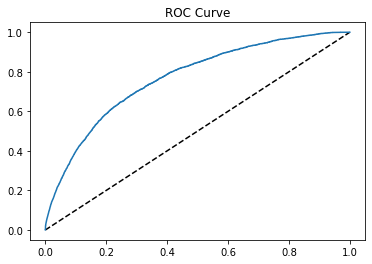

In [46]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = xgbcl.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.show()

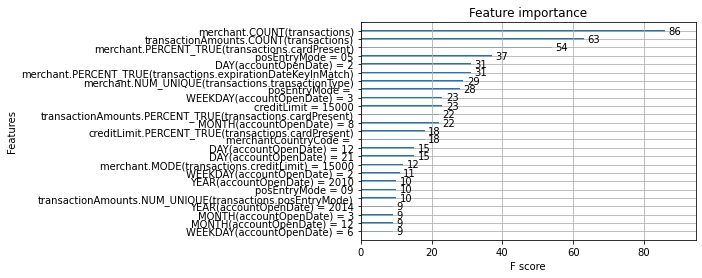

In [47]:
#What are the most important features in the dataset relating to fraud.  
dmatrix = xgb.DMatrix(data=X_train, label=y_train)

# Create the parameter dictionary: params
params = {"objective":"binary:logistic",'tree_method':'gpu_hist','n_jobs':-1}

# Train the model: 
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=20)

# Plot the feature importances
xgb.plot_importance(xg_reg,max_num_features = 25)
plt.show()


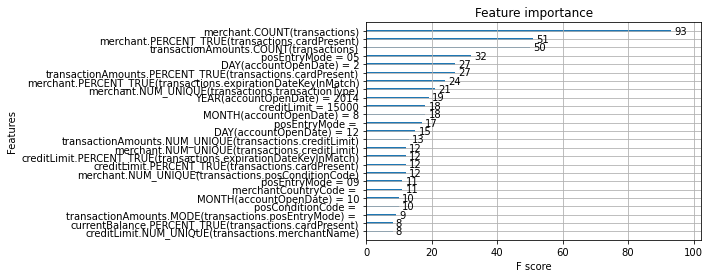

In [48]:
#What are the most important features in the dataset relating to fraud.  
dmatrix = xgb.DMatrix(data=X_test, label=y_test)

# Create the parameter dictionary: params
params = {"objective":"binary:logistic",'tree_method':'gpu_hist'}

# Train the model: 
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=20)

# Plot the feature importances
xgb.plot_importance(xg_reg,max_num_features = 25)
plt.show()

We are able to boost our model using auto-feature tools.  We See that the model is using a lot of different features to make its decision.  